In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_parquet('../Data/credit_card_data_train.parquet')

In [3]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  str    
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  str    
 4   category               1296675 non-null  str    
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  str    
 7   last                   1296675 non-null  str    
 8   gender                 1296675 non-null  str    
 9   street                 1296675 non-null  str    
 10  city                   1296675 non-null  str    
 11  state                  1296675 non-null  str    
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long                   129667

In [4]:
print(data.nunique())


Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64


In [5]:
#DF continning time of fraud
df_time_fraud = data.loc[data['is_fraud']==1 , ['unix_time']]

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

### We Observe many fraud Transaction Occurs near the same time

In [7]:
df_time_fraud['Date'] = pd.to_datetime(df_time_fraud['unix_time'], unit='s')
df_time_fraud

,unix_time,Date
2449,1325466397,2012-01-02 01:06:37
2472,1325468849,2012-01-02 01:47:29
2523,1325473523,2012-01-02 03:05:23
2546,1325475483,2012-01-02 03:38:03
2553,1325476547,2012-01-02 03:55:47
...,...,...
1295399,1371776408,2013-06-21 01:00:08
1295491,1371779615,2013-06-21 01:53:35
1295532,1371781016,2013-06-21 02:16:56
1295666,1371785180,2013-06-21 03:26:20


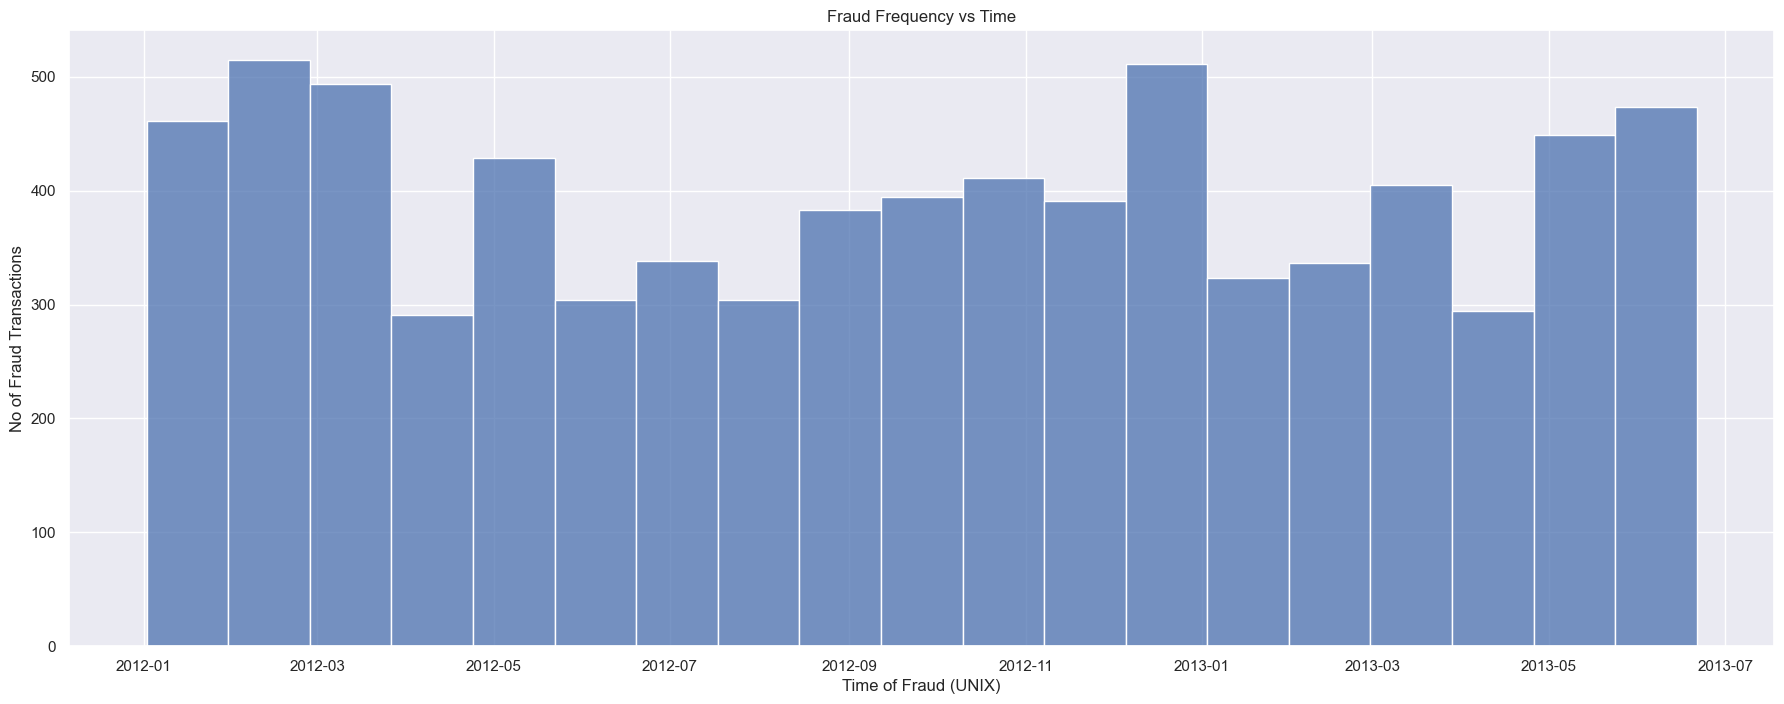

In [8]:
plt.figure(figsize=(22,8))
plt.title('Fraud Frequency vs Time')
sns.histplot(data = df_time_fraud, x="Date")
plt.xlabel('Time of Fraud (UNIX)')
plt.ylabel('No of Fraud Transactions')
plt.show()

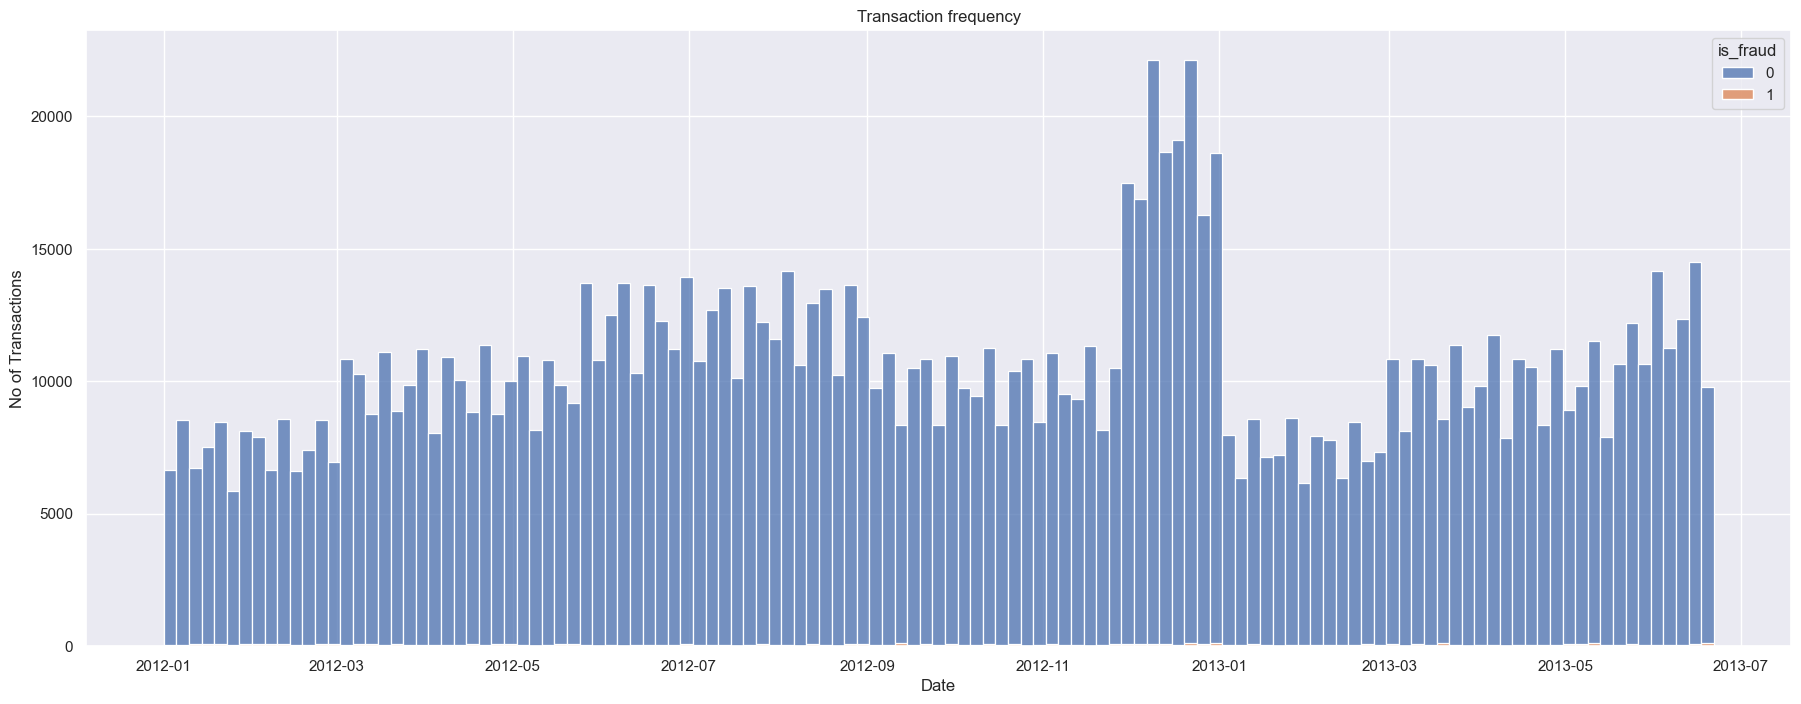

In [9]:
whole_data_transaction_time = data[['unix_time' , 'is_fraud']]
whole_data_transaction_time['Date'] = pd.to_datetime(whole_data_transaction_time['unix_time'] , unit='s')
plt.figure(figsize=(22,8))
plt.title("Transaction frequency")
sns.histplot(data = whole_data_transaction_time , x="Date" , hue="is_fraud", multiple="stack")
plt.xlabel("Date")
plt.ylabel('No of Transactions')
plt.show()

## We can Observe 3 clusters which concludes the following  
* Fraudster test the credit car first by spending 1$  
* Most of the Frauds are in the range of (200-400)$ or (600-1200)$, This may be due to daily payment limit on Card
* Most of the victims are in the age group of 20 to 60

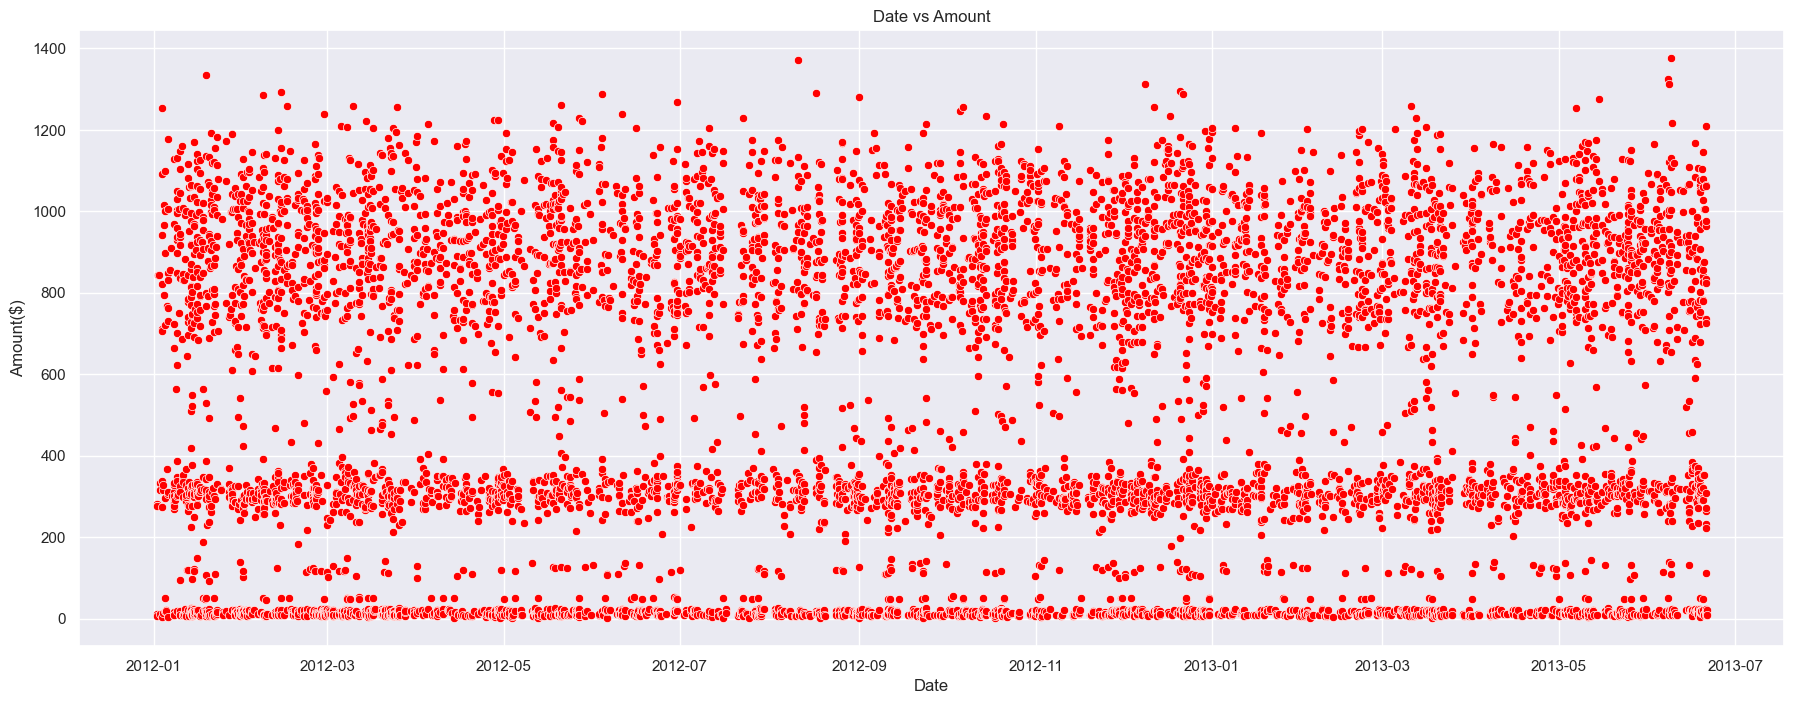

In [10]:
time_amount = data[['unix_time' , 'is_fraud' , 'amt']]
time_amount['Date'] = pd.to_datetime(whole_data_transaction_time['unix_time'] , unit='s')

time_amount_fraud = time_amount.loc[time_amount['is_fraud']==1]
plt.figure(figsize=(22,8))
plt.title("Date vs Amount")
sns.scatterplot(data = time_amount_fraud, x='Date',y='amt', color='red')
plt.xlabel("Date")
plt.ylabel("Amount($)")
plt.show()

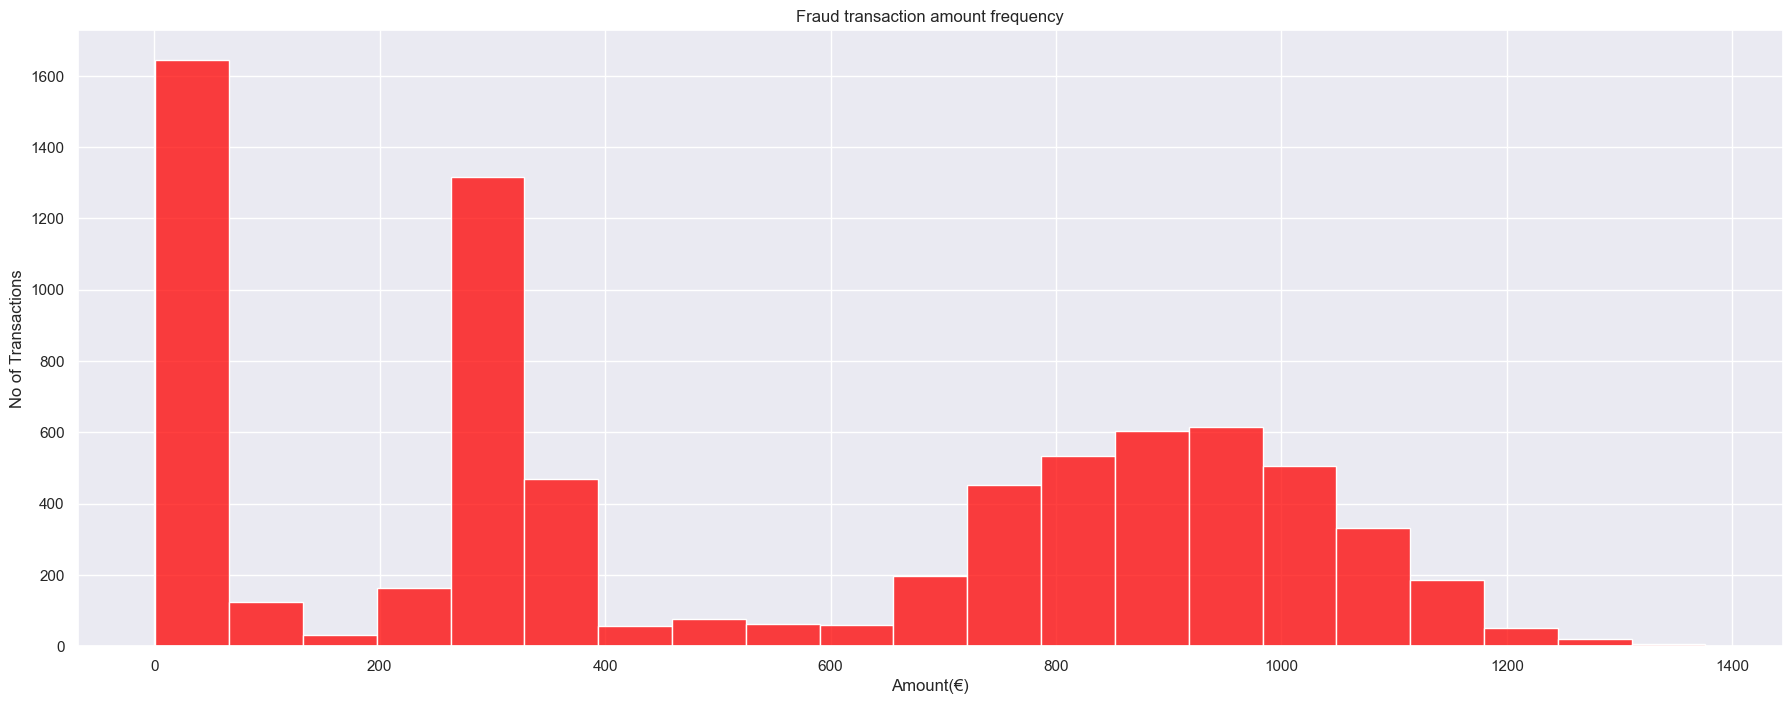

In [11]:
plt.figure(figsize=(22,8))
plt.title("Fraud transaction amount frequency")
sns.histplot(data = time_amount_fraud , x="amt" , color='red')
plt.xlabel("Amount(€)")
plt.ylabel('No of Transactions')
plt.show()

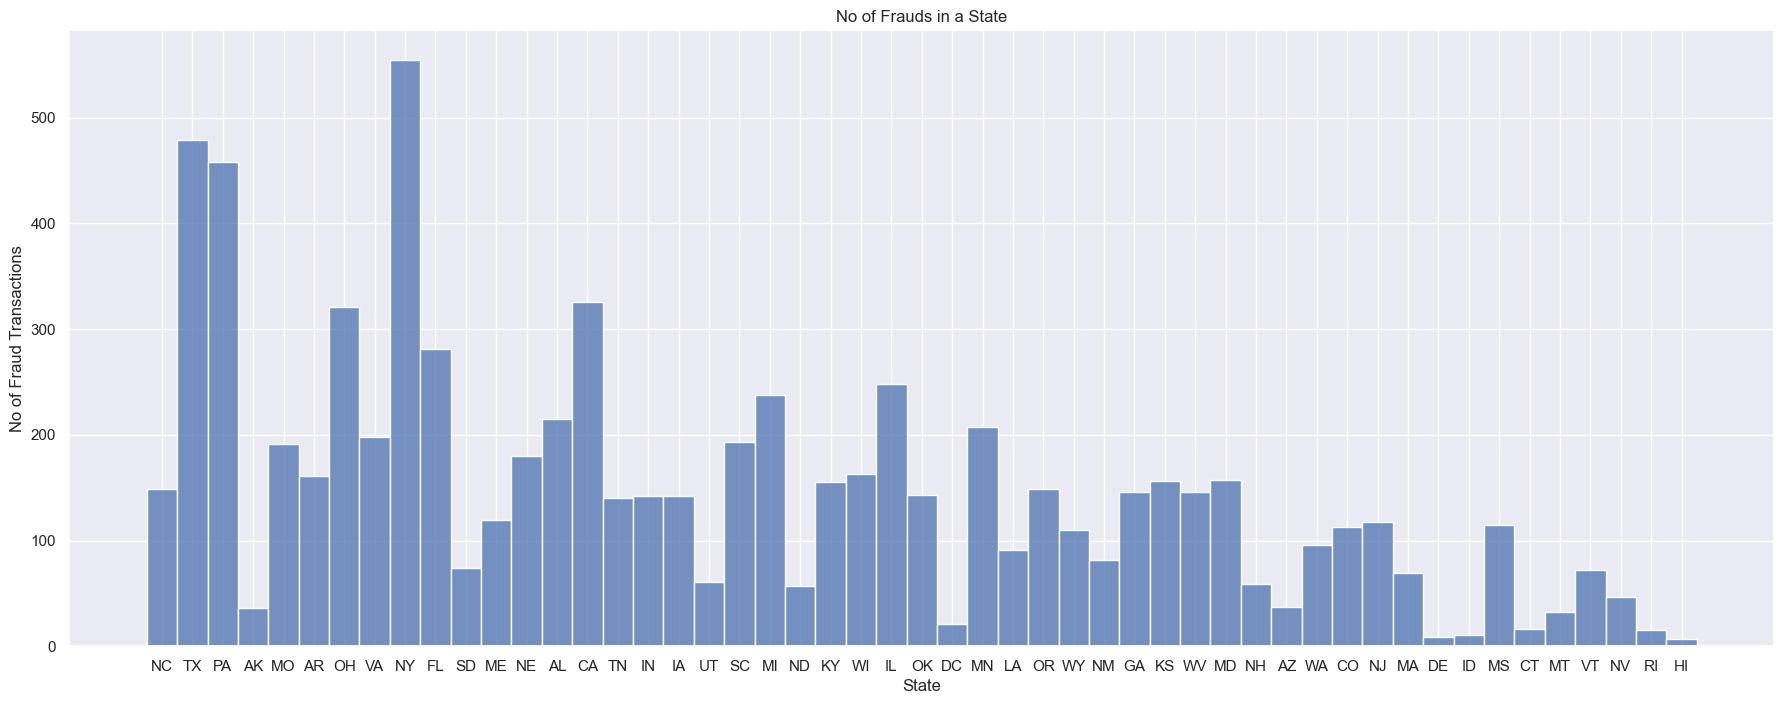

In [12]:
state_data = data[['state' , 'is_fraud' , 'amt']]
state_data = state_data.loc[state_data['is_fraud']==1]
plt.figure(figsize=(22,8))
plt.title("No of Frauds in a State")
sns.histplot(data = state_data, x="state")
plt.xlabel("State")
plt.ylabel('No of Fraud Transactions')
plt.show()

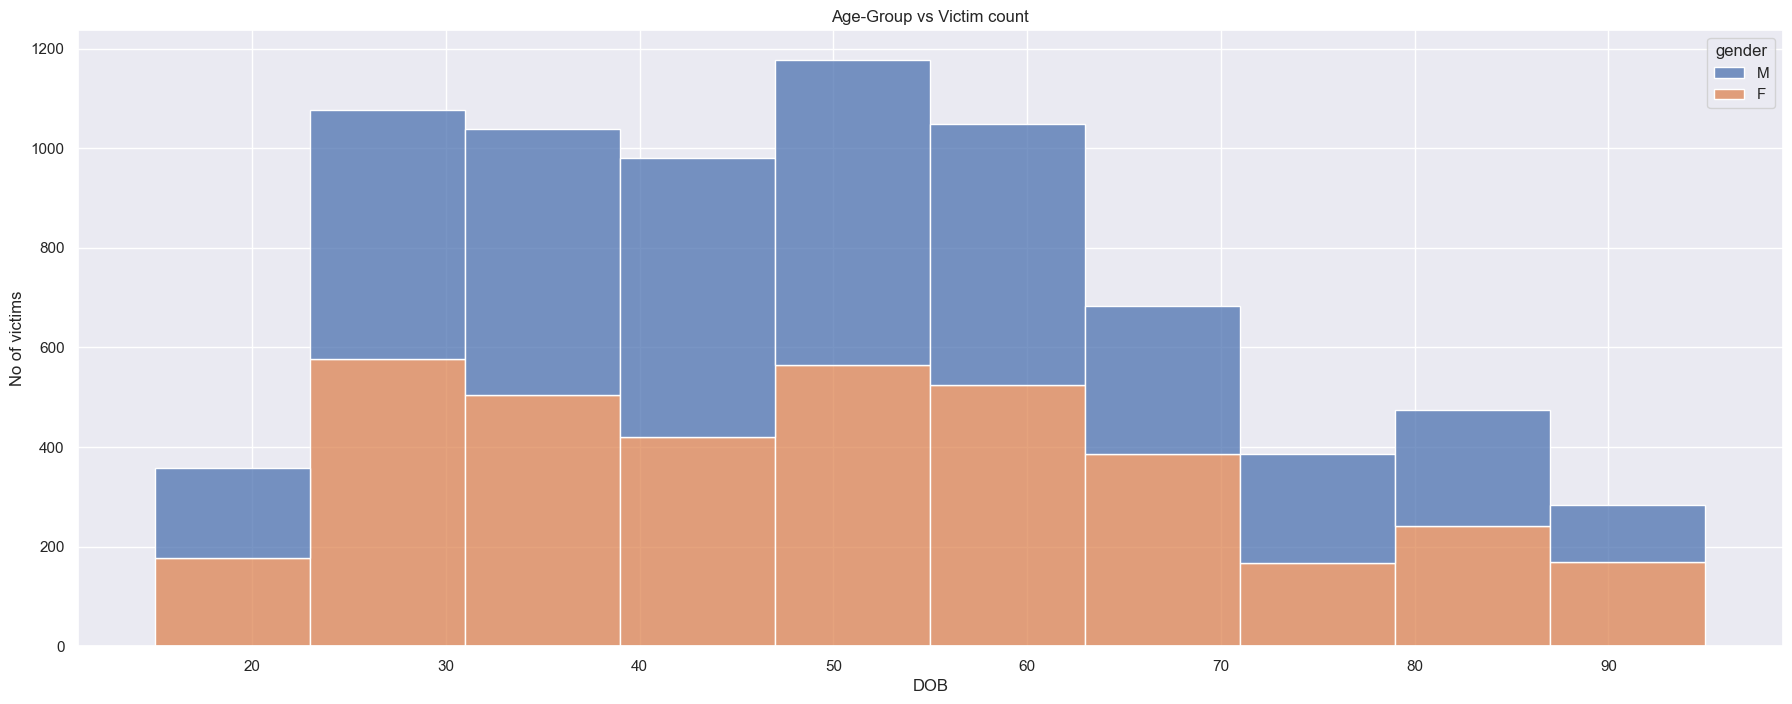

In [13]:
gender_data = data[['gender','is_fraud' , 'dob']]
gender_data['dob'] = pd.to_datetime(gender_data['dob'])
reference_date = pd.Timestamp("2021-01-01")
gender_data['age'] = (reference_date - gender_data['dob']).dt.days // 365
gender_data = gender_data.loc[gender_data['is_fraud']==1]
plt.figure(figsize=(22,8))
plt.title("Age-Group vs Victim count")
sns.histplot(data = gender_data, x="age", hue='gender' , multiple='stack', bins=10)
plt.xlabel("DOB")
plt.ylabel('No of victims')
plt.show()

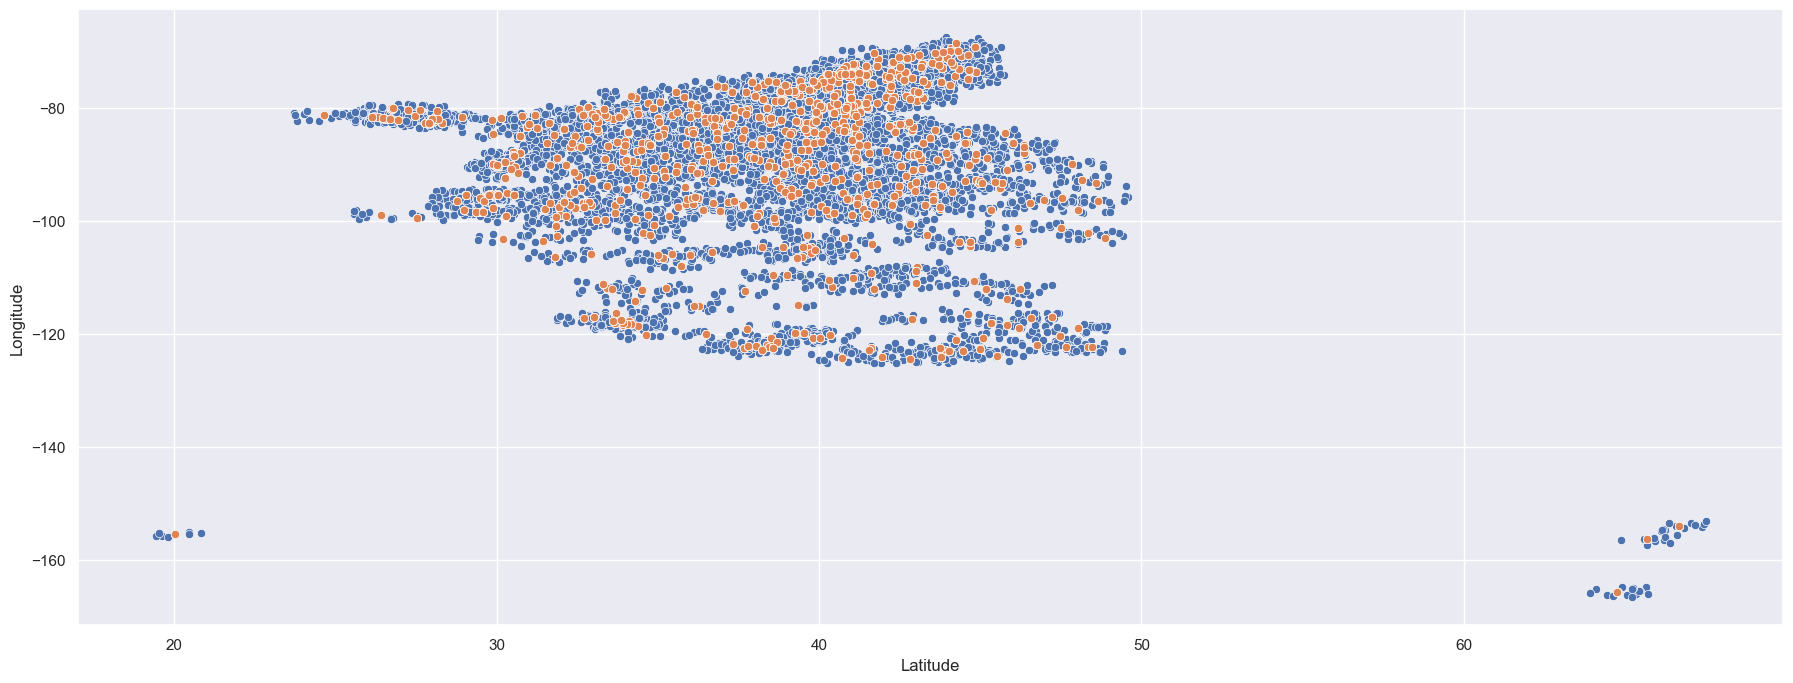

In [14]:
fraud_location = data[['lat','long','merch_lat','merch_long','is_fraud']].loc[data['is_fraud']==1]

plt.figure(figsize=(22,8))
sns.scatterplot(data=fraud_location, x='merch_lat', y='merch_long')
sns.scatterplot(data=fraud_location, x='lat', y='long')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    R = 3958.8 
    
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    # Haversine formula
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply the correct distance calculation
fraud_location['distance'] = haversine_distance(
    fraud_location['lat'], fraud_location['long'], 
    fraud_location['merch_lat'], fraud_location['merch_long']
)

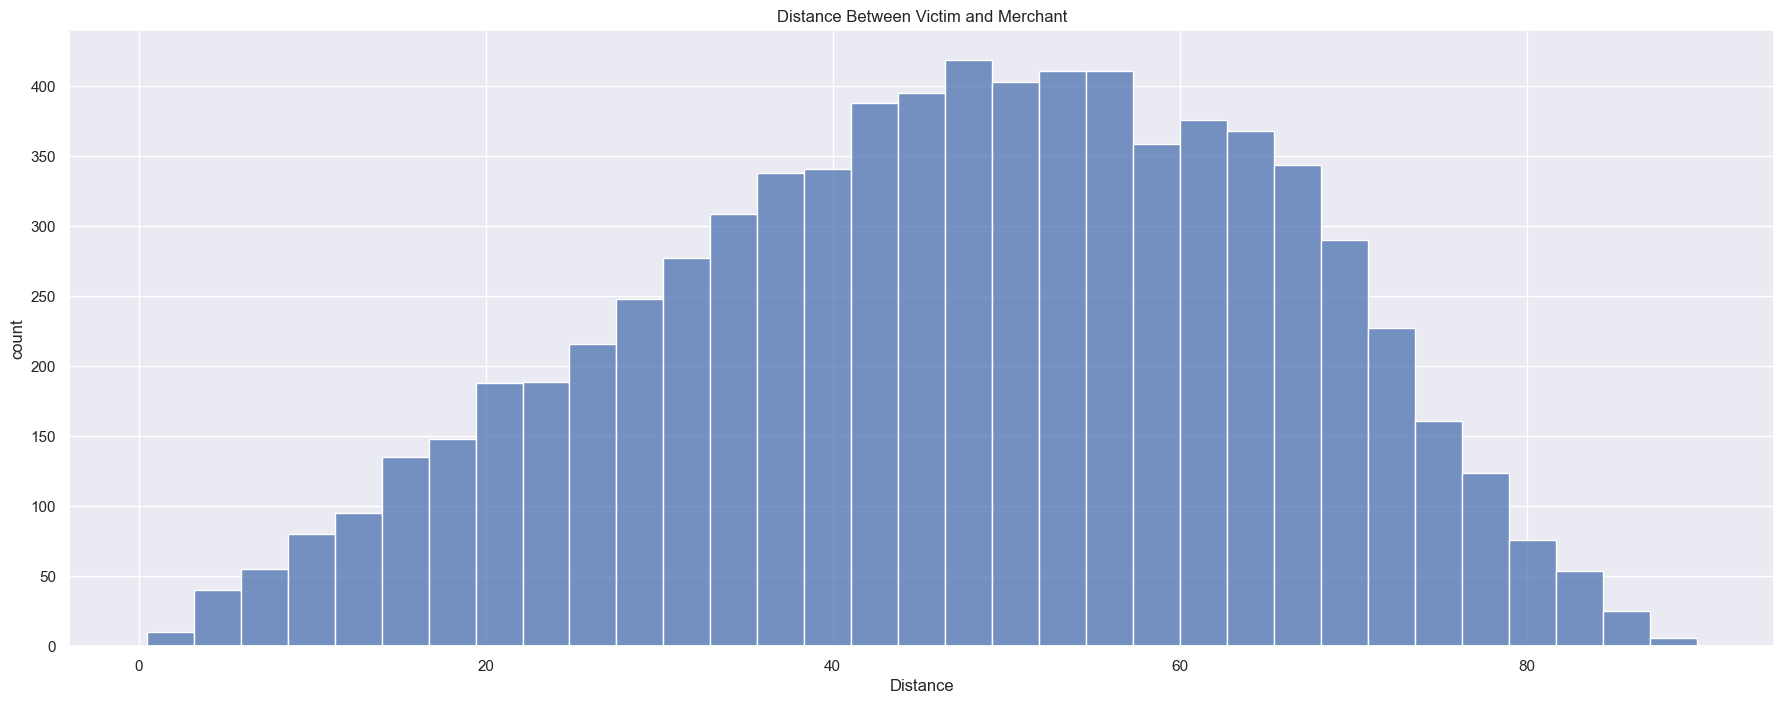

In [16]:
plt.figure(figsize=(22,8))
plt.title("Distance Between Victim and Merchant")
sns.histplot(data = fraud_location, x="distance")
plt.xlabel("Distance")
plt.ylabel('count')
plt.show()

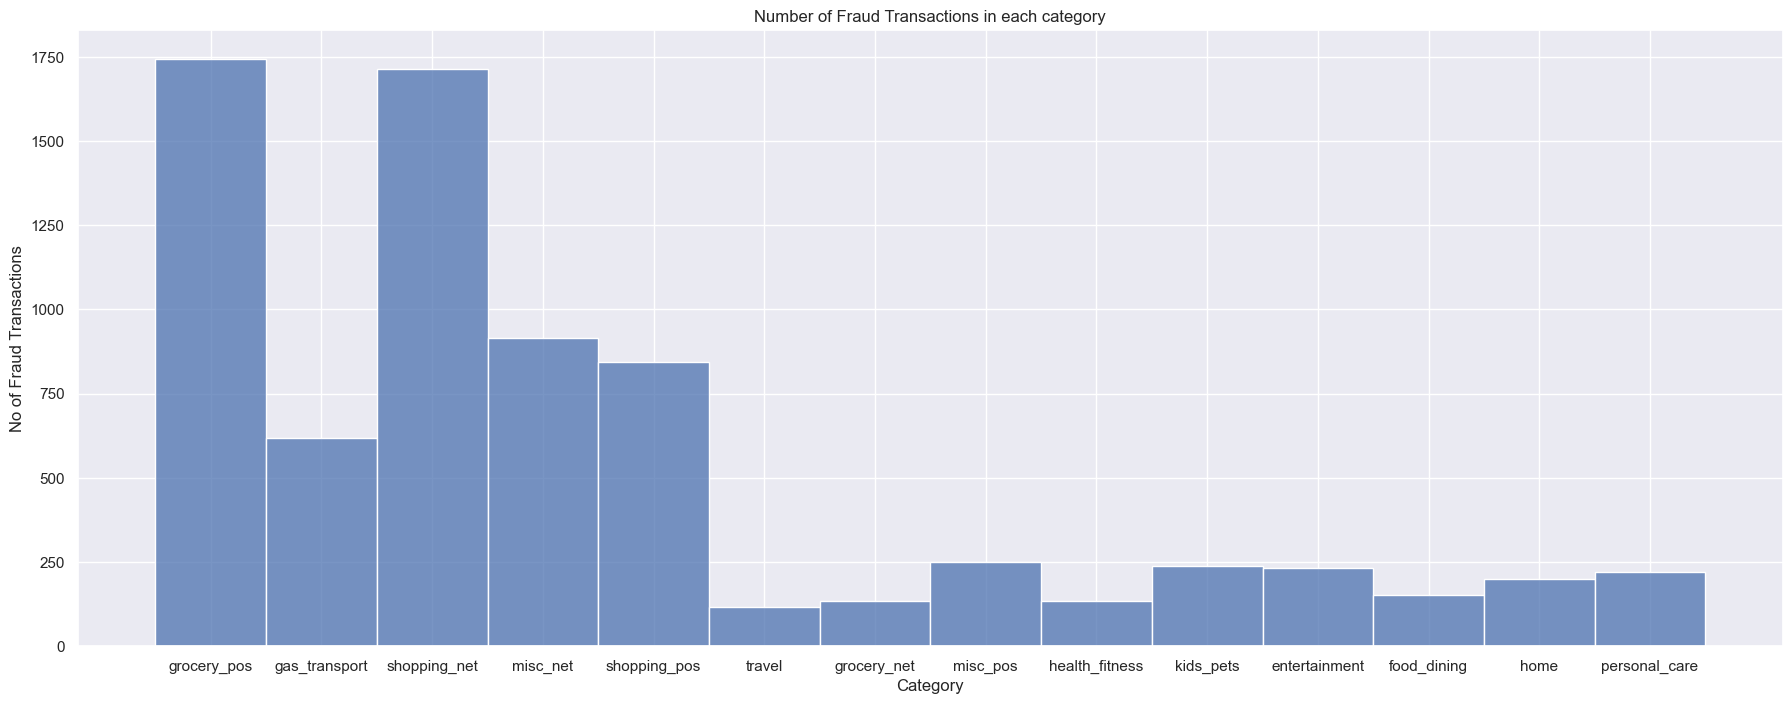

In [17]:
categories_fraud = data[['category','is_fraud']].loc[data['is_fraud']==1]

plt.figure(figsize=(22,8))
plt.title('Number of Fraud Transactions in each category')
sns.histplot(data = categories_fraud , x='category' )
plt.xlabel('Category')
plt.ylabel('No of Fraud Transactions')
plt.show()

* We can observe their are **7506** fraud transactions and only **762 credit card** that have been used for frauds this concludes that each card undergoes multiple transactions.  
* Most of the credit cards goes through 8 to 12 Fraud transaction during attack.

In [18]:
cc_num = data[['cc_num','is_fraud']].loc[data['is_fraud']==1]
cc_num

,cc_num,is_fraud
2449,4613314721966,1
2472,340187018810220,1
2523,340187018810220,1
2546,4613314721966,1
2553,340187018810220,1
...,...,...
1295399,3524574586339330,1
1295491,3524574586339330,1
1295532,4005676619255478,1
1295666,3560725013359375,1


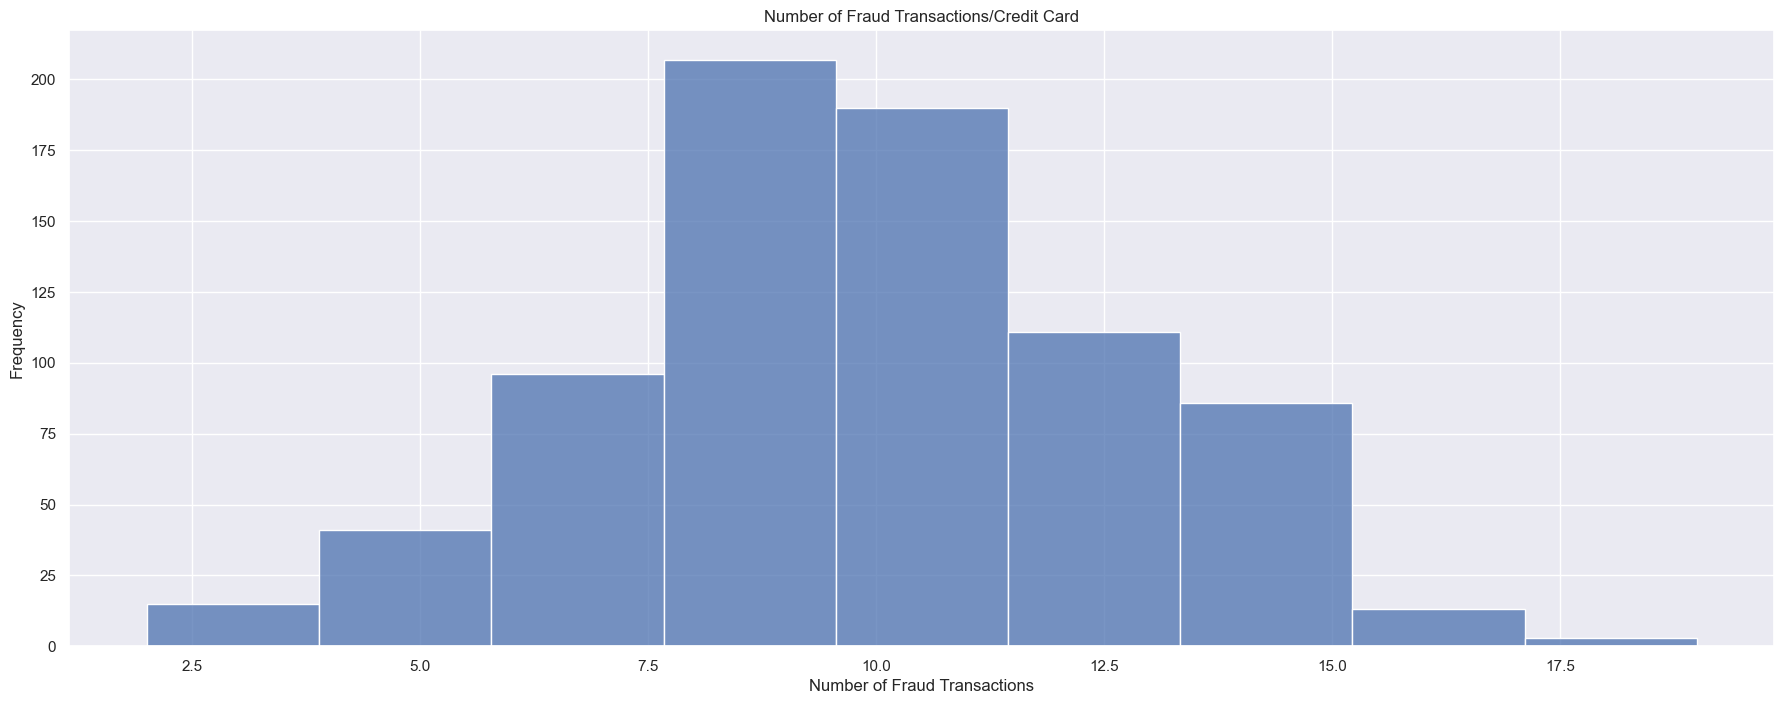

In [20]:
fraud_count = pd.DataFrame(cc_num['cc_num'].value_counts())
plt.figure(figsize=(22,8))
plt.title('Number of Fraud Transactions/Credit Card')
sns.histplot(data = fraud_count , x='count', bins=9)
plt.xlabel('Number of Fraud Transactions')
plt.ylabel('Frequency')
plt.show()

#### We can observe a very strong corelation between latitude and longitude of the card holder and merchant

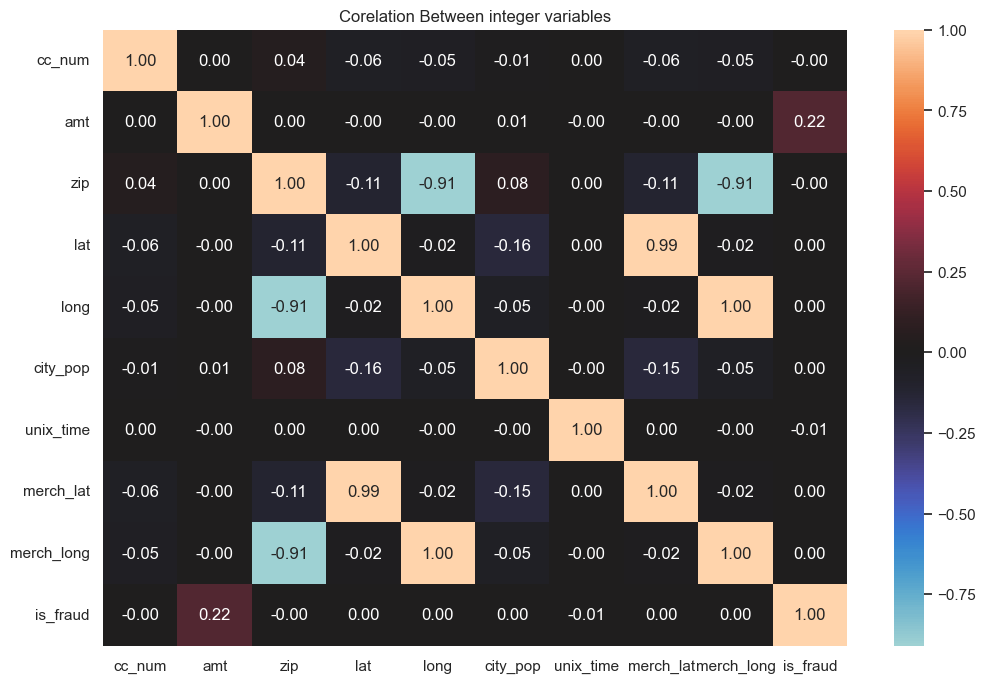

In [21]:
integer_cols = data.select_dtypes(include=['float64','int64']).columns
integer_cols = [col for col in integer_cols if data[col].nunique() > 1][1:]
plt.figure(figsize=(12,8))
sns.heatmap(data[integer_cols].corr(), center=0, annot=True, fmt=".2f")
plt.title("Corelation Between integer variables")
plt.show()

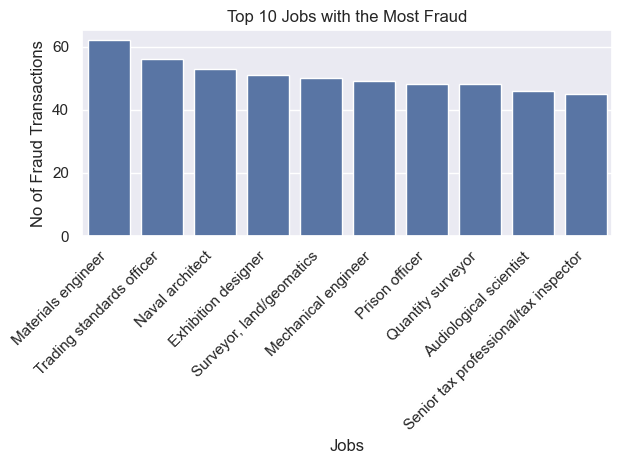

In [22]:
# Get top 10 jobs with most fraud
jobs_fraud = data[['job','is_fraud']].loc[data['is_fraud']==1]
top_10_jobs = jobs_fraud['job'].value_counts().head(10)

# Create bar plot

plt.title('Top 10 Jobs with the Most Fraud')
sns.barplot(x=top_10_jobs.index, y=top_10_jobs.values)
plt.xlabel('Jobs')
plt.ylabel('No of Fraud Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:

merchant_fraud = data[['merchant','is_fraud']].loc[data['is_fraud']==1]
merchant_fraud['merchant'].value_counts().head(10)

merchant
fraud_Rau and Sons       49
fraud_Cormier LLC        48
fraud_Kozey-Boehm        48
fraud_Doyle Ltd          47
fraud_Vandervort-Funk    47
fraud_Kilback LLC        47
fraud_Padberg-Welch      44
fraud_Kuhn LLC           44
fraud_Terry-Huel         43
fraud_Goyette Inc        42
Name: count, dtype: int64

In [27]:
merchant_fraud['merchant'].value_counts().describe()

count    679.000000
mean      11.054492
std       11.562258
min        1.000000
25%        3.000000
50%        5.000000
75%       16.000000
max       49.000000
Name: count, dtype: float64